<a href="https://colab.research.google.com/github/JoelForson/ECON5200-Applied-Data-Analytics-in-Economics/blob/main/Lab%202/%20%5BLab_2%5D_Deflating_History_with_FRED.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# Install the FRED API library
!pip install fredapi

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from fredapi import Fred

# Authenticate
# Replace the string below with YOUR unique API key from fred.stlouisfed.org
fred = Fred(api_key='19333dfa76b436c7f74dfdbbd46a9676')

In [6]:
# 1. Fetch the data series
print("Fetching data from FRED...")
wages = fred.get_series('AHETPI')
cpi = fred.get_series('CPIAUCSL')

# 2. Combine into a DataFrame
df = pd.DataFrame({'Nominal_Wage': wages, 'CPI': cpi})

# 3. Drop missing values (The wage data starts later than CPI data)
df = df.dropna()

# Inspect the raw data
print(df.head())
print(df.tail())

Fetching data from FRED...
            Nominal_Wage    CPI
1964-01-01          2.50  30.94
1964-02-01          2.50  30.91
1964-03-01          2.51  30.94
1964-04-01          2.52  30.95
1964-05-01          2.52  30.98
            Nominal_Wage      CPI
2025-07-01         31.35  322.132
2025-08-01         31.45  323.364
2025-09-01         31.52  324.368
2025-11-01         31.73  325.031
2025-12-01         31.76  326.030


In [7]:
def get_real_wage(nominal_col, cpi_col):
    """
    Takes a nominal column and a CPI column.
    Returns a new column adjusted for inflation (Real Dollars).
    """
    # 1. Get the CPI of the most recent date (Today's Prices)
    # .iloc[-1] grabs the very last row in the data
    cpi_today = cpi_col.iloc[-1]

    # 2. The Formula: (Nominal / Old_CPI) * CPI_Today
    real_col = (nominal_col / cpi_col) * cpi_today

    return real_col

# Apply the function to create a new column
# We feed the "Machine" our two columns:
df['Real_Wage'] = get_real_wage(df['Nominal_Wage'], df['CPI'])

# Check the result - Notice how Real Wages are different from Nominal!
print(df.tail())

            Nominal_Wage      CPI  Real_Wage
2025-07-01         31.35  322.132  31.729355
2025-08-01         31.45  323.364  31.709292
2025-09-01         31.52  324.368  31.681502
2025-11-01         31.73  325.031  31.827524
2025-12-01         31.76  326.030  31.760000


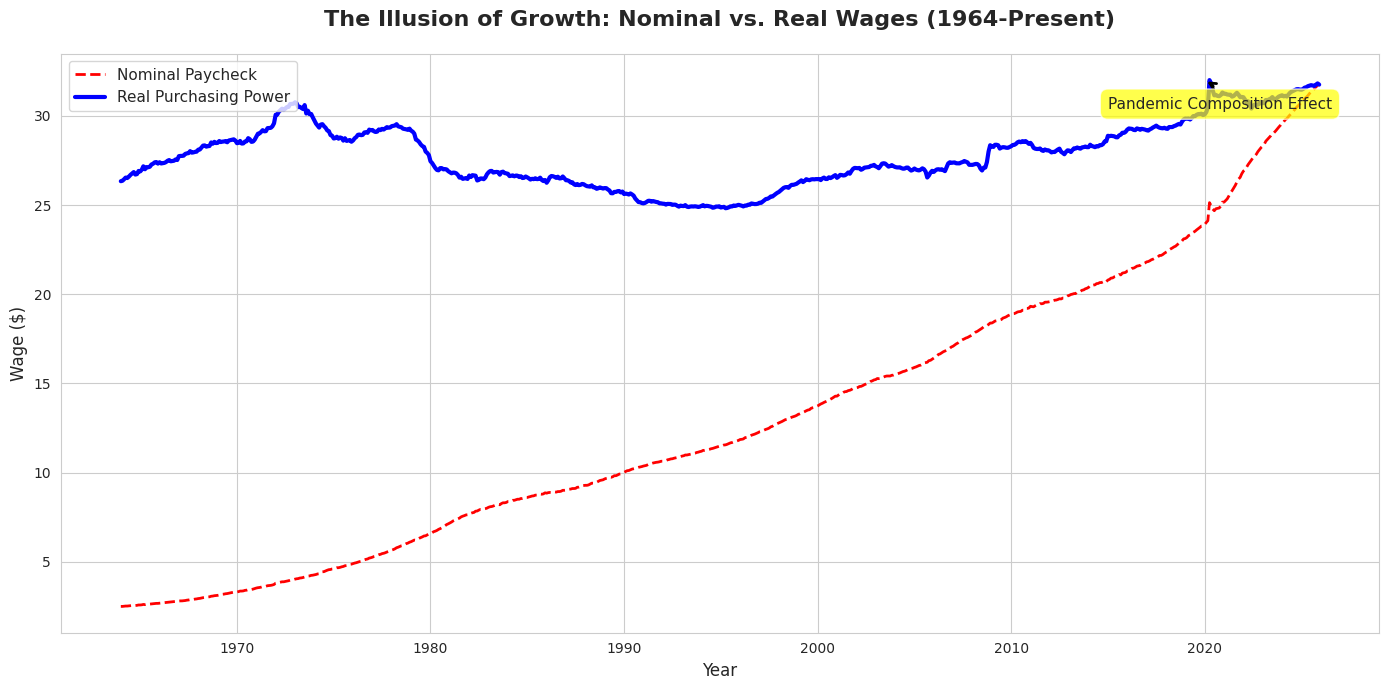

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style
sns.set_style("whitegrid")

# Create figure and axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot the lines
ax.plot(df.index, df['Nominal_Wage'],
        color='red',
        linestyle='--',
        linewidth=2,
        label='Nominal Paycheck')

ax.plot(df.index, df['Real_Wage'],
        color='blue',
        linewidth=3,
        label='Real Purchasing Power')

# Add title and labels
ax.set_title('The Illusion of Growth: Nominal vs. Real Wages (1964-Present)',
             fontsize=16,
             fontweight='bold',
             pad=20)
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Wage ($)', fontsize=12)

# Add legend
ax.legend(loc='upper left', fontsize=11, frameon=True)

# Add annotation for 2020 pandemic spike
# Adjust the xy coordinates based on your actual data
ax.annotate('Pandemic Composition Effect',
            xy=(pd.Timestamp('2020-01-01'), df.loc['2020', 'Real_Wage'].max()),
            xytext=(pd.Timestamp('2015-01-01'), df['Real_Wage'].max() * 0.95),
            arrowprops=dict(arrowstyle='->',
                          connectionstyle='arc3,rad=0.3',
                          color='black',
                          lw=2),
            fontsize=11,
            bbox=dict(boxstyle='round,pad=0.5',
                     facecolor='yellow',
                     alpha=0.7))

# Improve layout
plt.tight_layout()

# Display the plot
plt.show()

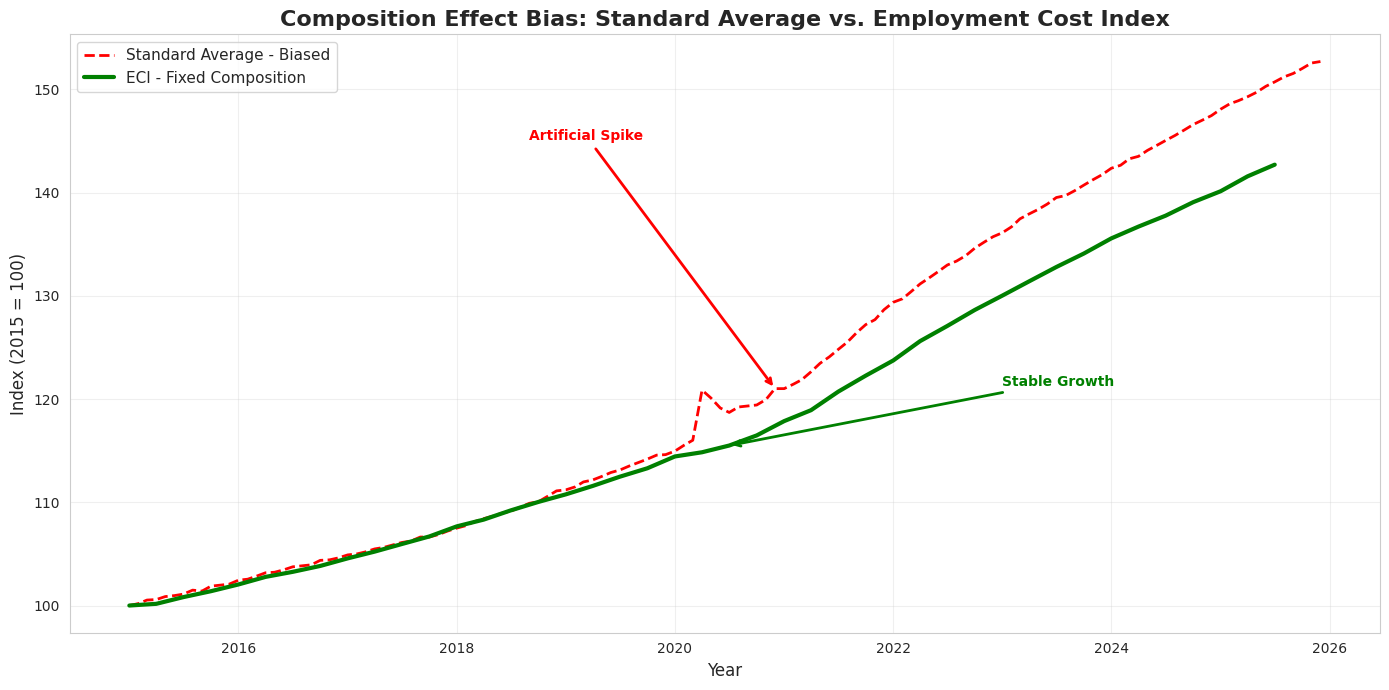

In [15]:
import matplotlib.pyplot as plt
import pandas as pd

# Fetch Employment Cost Index data
eci = fred.get_series('ECIWAG')

# Filter both series to 2015 onwards
wages_filtered = wages['2015-01-01':]
eci_filtered = eci['2015-01-01':]

# Rebase both series to 100
wages_rebased = (wages_filtered / wages_filtered.iloc[0]) * 100
eci_rebased = (eci_filtered / eci_filtered.iloc[0]) * 100

# Create the plot
fig, ax = plt.subplots(figsize=(14, 7))

# Plot both lines
ax.plot(wages_rebased.index, wages_rebased,
        color='red',
        linestyle='--',
        linewidth=2,
        label='Standard Average - Biased')

ax.plot(eci_rebased.index, eci_rebased,
        color='green',
        linewidth=3,
        label='ECI - Fixed Composition')

# Add title and labels
ax.set_title('Composition Effect Bias: Standard Average vs. Employment Cost Index',
             fontsize=16,
             fontweight='bold')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Index (2015 = 100)', fontsize=12)

# Add legend
ax.legend(loc='upper left', fontsize=11)

# Find 2020 data for annotations
wages_2020 = wages_rebased[wages_rebased.index.year == 2020]
eci_2020 = eci_rebased[eci_rebased.index.year == 2020]

# Add annotation for 2020 divergence - Artificial Spike
if len(wages_2020) > 0:
    spike_date = wages_2020.idxmax()
    spike_value = wages_2020.max()

    ax.annotate('Artificial Spike',
                xy=(spike_date, spike_value),
                xytext=(wages_rebased.index[len(wages_rebased)//3], wages_rebased.max() * 0.95),
                arrowprops=dict(arrowstyle='->',
                              color='red',
                              lw=2),
                fontsize=10,
                color='red',
                fontweight='bold')

# Add annotation for 2020 - Stable Growth
if len(eci_2020) > 0:
    stable_date = eci_2020.index[len(eci_2020)//2]
    stable_value = eci_2020.iloc[len(eci_2020)//2]

    ax.annotate('Stable Growth',
                xy=(stable_date, stable_value),
                xytext=(eci_rebased.index[-len(eci_rebased)//4], eci_rebased.max() * 0.85),
                arrowprops=dict(arrowstyle='->',
                              color='green',
                              lw=2),
                fontsize=10,
                color='green',
                fontweight='bold')

# Add grid
ax.grid(True, alpha=0.3)

# Tight layout
plt.tight_layout()

# Display
plt.show()